In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import log_loss, accuracy_score, classification_report, plot_confusion_matrix, balanced_accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample = pd.read_csv('../input/sample_submission.csv')

In [3]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


## 标签编码

In [4]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train.author.values)

In [5]:
print(train[:10]['author'].to_numpy())
print(y[:10])

['EAP' 'HPL' 'EAP' 'MWS' 'HPL' 'MWS' 'EAP' 'EAP' 'EAP' 'MWS']
[0 1 0 2 1 2 0 0 0 2]


In [6]:
print(lbl_enc.classes_)

['EAP' 'HPL' 'MWS']


## 训练样本拆分

origin: [0.40349354 0.28780837 0.30869809]
train: [0.40349583 0.28778162 0.30872255]
valid: [0.40347293 0.28804903 0.30847804]


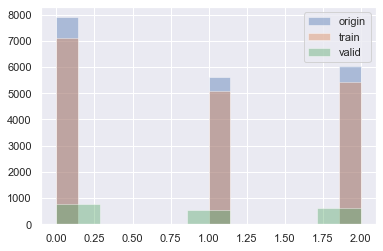

In [7]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.text.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)
sns.distplot(y, label='origin', kde=False, norm_hist=False)
sns.distplot(ytrain, label='train', kde=False, norm_hist=False)
sns.distplot(yvalid, label='valid', kde=False, norm_hist=False)
plt.legend()
print('origin:', np.bincount(y)/len(y))
print('train:', np.bincount(ytrain)/len(ytrain))
print('valid:', np.bincount(yvalid)/len(yvalid))

## 特征提取

In [8]:
ctv = CountVectorizer(
    analyzer='word',token_pattern=r'\w{1,}',
    ngram_range=(1, 3), stop_words = 'english'
)
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [9]:
print(xtrain[0])
print(xtrain_ctv[0].nonzero())

Her hair was the brightest living gold, and despite the poverty of her clothing, seemed to set a crown of distinction on her head.
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0]), array([ 38996,  39003,  39004,  56419,  56435,  56436,  71852,  71857,
        71858,  84859,  84925,  84926,  92662,  92677, 146831, 146842,
       146843, 153806, 153829, 153830, 158208, 203649, 203713, 203714,
       266371, 266382, 266383, 312719, 312787, 312788]))


In [10]:
features = np.array(ctv.get_feature_names())

In [11]:
print(features[xtrain_ctv[0].nonzero()[1]])

['brightest' 'brightest living' 'brightest living gold' 'clothing'
 'clothing set' 'clothing set crown' 'crown' 'crown distinction'
 'crown distinction head' 'despite' 'despite poverty'
 'despite poverty clothing' 'distinction' 'distinction head' 'gold'
 'gold despite' 'gold despite poverty' 'hair' 'hair brightest'
 'hair brightest living' 'head' 'living' 'living gold'
 'living gold despite' 'poverty' 'poverty clothing' 'poverty clothing set'
 'set' 'set crown' 'set crown distinction']


## 训练逻辑回归模型

In [12]:
clf = LogisticRegression(C=2.7825594, max_iter=1000)
clf.fit(xtrain_ctv, ytrain)

LogisticRegression(C=2.7825594, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## 模型评估

In [13]:
predictions = clf.predict_proba(xtrain_ctv)
print ("train set: logloss: %0.3f" % (log_loss(ytrain, predictions), ))

predictions = clf.predict_proba(xvalid_ctv)
print ("valid set: logloss: %0.3f" % (log_loss(yvalid, predictions), ))

train set: logloss: 0.040
valid set: logloss: 0.532


In [14]:
predictions = clf.predict(xtrain_ctv)
print('train set')
print(classification_report(ytrain, predictions, target_names=lbl_enc.classes_))

print('-' * 70)
predictions = clf.predict(xvalid_ctv)
print('validate set')
print(classification_report(yvalid, predictions, target_names=lbl_enc.classes_, digits=3))

train set
              precision    recall  f1-score   support

         EAP       1.00      1.00      1.00      7110
         HPL       1.00      1.00      1.00      5071
         MWS       1.00      1.00      1.00      5440

    accuracy                           1.00     17621
   macro avg       1.00      1.00      1.00     17621
weighted avg       1.00      1.00      1.00     17621

----------------------------------------------------------------------
validate set
              precision    recall  f1-score   support

         EAP      0.731     0.848     0.785       790
         HPL      0.840     0.706     0.767       564
         MWS      0.789     0.742     0.765       604

    accuracy                          0.774      1958
   macro avg      0.787     0.765     0.772      1958
weighted avg      0.780     0.774     0.774      1958



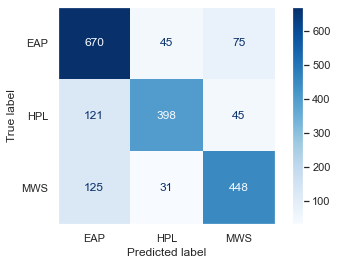

In [15]:
plot_confusion_matrix(clf, xvalid_ctv, yvalid, display_labels=lbl_enc.classes_, values_format='d', cmap='Blues')
plt.grid(False)

In [16]:
print(
    'accuracy: %.3f balanced accuracy: %.3f' % (
        accuracy_score(yvalid, clf.predict(xvalid_ctv)),
        balanced_accuracy_score(yvalid, clf.predict(xvalid_ctv)),
    )
)

accuracy: 0.774 balanced accuracy: 0.765


## 平衡各类训练数据

5071 examples chosen from each class, got 15213 balanced train examples


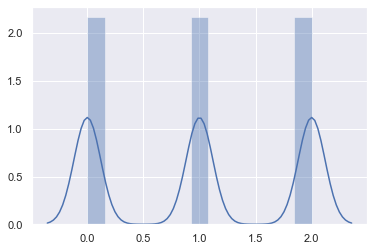

In [17]:
from scipy.sparse import vstack
from sklearn.utils import shuffle

num_classes = len(lbl_enc.classes_)
balanced_num = min(map(lambda label: xtrain_ctv[ytrain==label].shape[0], range(num_classes)))
l = tuple(map(lambda label: xtrain_ctv[ytrain==label][:balanced_num], range(num_classes)))
balanced_xtrain_ctv = vstack(l)
balanced_ytrain = np.repeat(range(num_classes), balanced_num)

balanced_xtrain_ctv, balanced_ytrain = shuffle(balanced_xtrain_ctv, balanced_ytrain)
print('%d examples chosen from each class, got %d balanced train examples' % (balanced_num, len(balanced_ytrain)))
sns.distplot(balanced_ytrain)

In [18]:
clfb = LogisticRegression(C=2.7825594, max_iter=1000)
clfb.fit(balanced_xtrain_ctv, balanced_ytrain)

LogisticRegression(C=2.7825594, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

accuracy: 0.776 balanced accuracy: 0.774


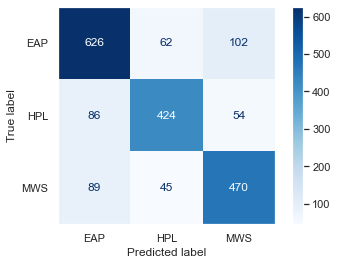

In [19]:
plot_confusion_matrix(clfb, xvalid_ctv, yvalid, display_labels=lbl_enc.classes_, values_format='d', cmap='Blues')
plt.grid(False)
print(
    'accuracy: %.3f balanced accuracy: %.3f' % (
        accuracy_score(yvalid, clfb.predict(xvalid_ctv)),
        balanced_accuracy_score(yvalid, clfb.predict(xvalid_ctv)),
    )
)